In [1]:
import ast
import pathlib
import sys

import numpy as np
import pandas as pd
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")


import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
import argparse

In [2]:
# set up the parser
parser = argparse.ArgumentParser(description="Train MLP model")

# add arguments to parser
parser.add_argument(
    "--CELL_TYPE",
    type=str,
    default="all",
    help="Cell type to train model on. Default is all",
)

parser.add_argument(
    "--MODEL_NAME",
    type=str,
    default="MLP",
    help="Model name to train. Default is MLP",
)

parser.add_argument(
    "--SHUFFLE",
    type=str,
    default="False",
    help="Shuffle data before training. Default is False",
)

# parse the arguments
args = parser.parse_args()

CELL_TYPE = args.CELL_TYPE
MODEL_NAME = args.MODEL_NAME
SHUFFLE = args.SHUFFLE
SHUFFLE = ast.literal_eval(SHUFFLE)
print(CELL_TYPE, MODEL_NAME, SHUFFLE)

In [3]:
# CELL_TYPE = "SHSY5Y"
# MODEL_NAME = "MultiClass_MLP"
# SHUFFLE = False

In [4]:
ml_configs_file = pathlib.Path("../../MLP_utils/multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME

mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

# load in the class weights
class_weights_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/class_weights/{CELL_TYPE}/multi_class/class_weights.txt"
).resolve(strict=True)
# read the class weights into a list for use in the loss function as a list
class_weights = []
with open(class_weights_file_path, "r") as f:
    for line in f:
        class_weights.append(float(line.strip()))
# check the class weights are correct
print(class_weights)

[0.954878893196544, 0.4803479499984947, 0.5647731568049614]


In [5]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path)

In [6]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(f"../../MLP_utils/ground_truth.toml").resolve(
    strict=True
)
treatment_splits_file_path = pathlib.Path(f"../../MLP_utils/splits.toml").resolve(
    strict=True
)
# read toml files
ground_truth = toml.load(ground_truth_file_path)
treatment_splits = toml.load(treatment_splits_file_path)

In [7]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [8]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is Off


In [9]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_groups_list,
    axis=1,
)
df1["pyroptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_groups_list,
    axis=1,
)
df1["healthy"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in healthy_groups_list,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df1["labels"] = df1.apply(
    lambda row: "apoptosis"
    if row["apoptosis"]
    else "pyroptosis"
    if row["pyroptosis"]
    else "healthy",
    axis=1,
)
# # drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [10]:
# set path for index file
index_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/indexes/{params.CELL_TYPE}/multi_class/{params.MODEL_NAME}_data_split_indexes.tsv"
).resolve(strict=True)

# read index file
index_df = pd.read_csv(index_file_path, sep="\t")
index_df.head()

,labeled_data_index,label
0,379883,train
1,6688,train
2,293841,train
3,117560,train
4,213514,train


In [11]:
# get train, validation, test, and holdout indexes
train_indexes = index_df.loc[index_df["label"] == "train"]["labeled_data_index"]
val_indexes = index_df.loc[index_df["label"] == "val"]["labeled_data_index"]
test_indexes = index_df.loc[index_df["label"] == "test"]["labeled_data_index"]
treatment_holdout = index_df.loc[index_df["label"] == "treatment_holdout"][
    "labeled_data_index"
]
holdout_indexes = index_df.loc[index_df["label"] == "holdout"]["labeled_data_index"]
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)

assert (
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
) == index_df.shape[0]

(165097,) (41275,) (218078,) 424450     93196
424451     93197
424452     93198
424453     93199
424454     93200
           ...  
446996    509986
446997    509987
446998    509988
446999    509989
447000    509990
Name: labeled_data_index, Length: 22551, dtype: int64 (150901,)


In [12]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_descriptive["labels"] = df1["labels"]
df_values = df1.drop(columns=df_metadata)

/tmp/ipykernel_84456/61520660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descriptive["labels"] = df1["labels"]


In [13]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "labels",
        "new_labels",
    ],
    axis=1,
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()
df_labels.drop_duplicates(inplace=True)
# pandas chaining to reset index and drop old index
df_labels.reset_index(drop=True, inplace=True)

/tmp/ipykernel_84456/1683257534.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels.drop_duplicates(inplace=True)


In [14]:
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)
print(
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
)

(165097,) (41275,) (218078,) 424450     93196
424451     93197
424452     93198
424453     93199
424454     93200
           ...  
446996    509986
446997    509987
446998    509988
446999    509989
447000    509990
Name: labeled_data_index, Length: 22551, dtype: int64 (150901,)
597902


In [15]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.iloc[train_indexes.values]
X_val = df_values_X.iloc[val_indexes.values]
X_test = df_values_X.iloc[test_indexes.values]
X_treatment_holdout = df_values_X.iloc[treatment_holdout.values]
X_holdout = df_values_X.iloc[holdout_indexes.values]

Y_train = df_values_Y.iloc[train_indexes.values]
Y_val = df_values_Y.iloc[val_indexes.values]
Y_test = df_values_Y.iloc[test_indexes.values]
Y_treatment_holdout = df_values_Y.iloc[treatment_holdout.values]
Y_holdout = df_values_Y.iloc[holdout_indexes.values]

metadata_train = df_descriptive.iloc[train_indexes.values]
metadata_val = df_descriptive.iloc[val_indexes.values]
metadata_test = df_descriptive.iloc[test_indexes.values]
metadata_treatment_holdout = df_descriptive.iloc[treatment_holdout.values]
metadata_holdout = df_descriptive.iloc[holdout_indexes.values]

In [16]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)
print(
    Y_treatment_holdout[Y_treatment_holdout == 0].shape,
    Y_treatment_holdout[Y_treatment_holdout == 1].shape,
    Y_treatment_holdout[Y_treatment_holdout == 2].shape,
)
print(
    Y_holdout[Y_holdout == 0].shape,
    Y_holdout[Y_holdout == 1].shape,
    Y_holdout[Y_holdout == 2].shape,
)

(7972,) (93463,) (63662,)
(1993,) (23367,) (15915,)
(9965,) (116830,) (91283,)
(0,) (0,) (22551,)
(7048,) (77041,) (66812,)


In [17]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_treatment_holdout.reset_index(drop=True, inplace=True)
X_holdout.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Y_treatment_holdout.reset_index(drop=True, inplace=True)
Y_holdout.reset_index(drop=True, inplace=True)

In [18]:
print(
    X_train.shape, X_val.shape, X_test.shape, X_treatment_holdout.shape, X_holdout.shape
)
print(
    Y_train.shape, Y_val.shape, Y_test.shape, Y_treatment_holdout.shape, Y_holdout.shape
)

(165097, 1251) (41275, 1251) (218078, 1251) (22551, 1251) (150901, 1251)
(165097,) (41275,) (218078,) (22551,) (150901,)


#### Split Data - All Models can proceed through this point

In [19]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [20]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  3
Multi_Class


In [21]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [22]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.645394).  Saving model ...
	 Train_Loss: 0.6718 Train_Acc: 69.061 Val_Loss: 0.6454  BEST VAL Loss: 0.6454  Val_Acc: 67.036

Epoch 1: Validation loss decreased (0.645394 --> 0.631759).  Saving model ...
	 Train_Loss: 0.6472 Train_Acc: 71.010 Val_Loss: 0.6318  BEST VAL Loss: 0.6318  Val_Acc: 68.516

Epoch 2: Validation loss decreased (0.631759 --> 0.626537).  Saving model ...
	 Train_Loss: 0.6320 Train_Acc: 71.886 Val_Loss: 0.6265  BEST VAL Loss: 0.6265  Val_Acc: 69.085

Epoch 3: Validation loss decreased (0.626537 --> 0.616308).  Saving model ...
	 Train_Loss: 0.6199 Train_Acc: 72.680 Val_Loss: 0.6163  BEST VAL Loss: 0.6163  Val_Acc: 71.445

Epoch 4: Validation loss decreased (0.616308 --> 0.607818).  Saving model ...
	 Train_Loss: 0.6108 Train_Acc: 73.112 Val_Loss: 0.6078  BEST VAL Loss: 0.6078  Val_Acc: 72.274

Epoch 5: Validation loss decreased (0.607818 --> 0.603182).  Saving model ...
	 Train_Loss: 0.6028 Train_Acc: 73.605 Val_Loss:

In [23]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffled_data",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffled_data


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


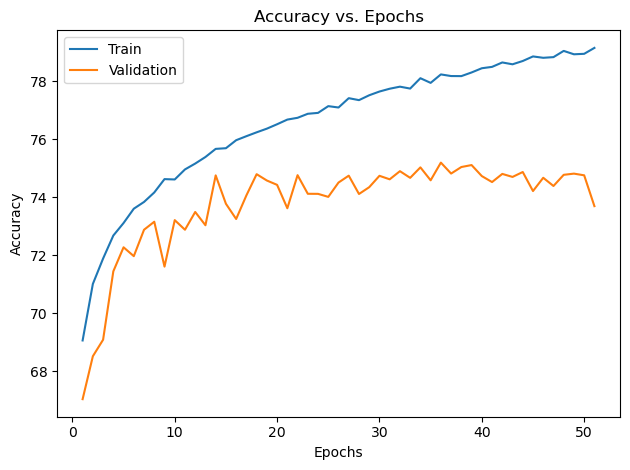

In [24]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


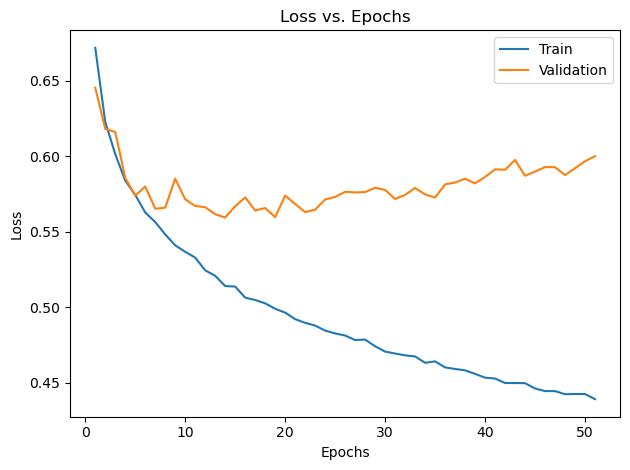

In [25]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [26]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [27]:
stats_df = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7972
           1       0.83      0.83      0.83     93463
           2       0.75      0.74      0.75     63662

    accuracy                           0.80    165097
   macro avg       0.82      0.83      0.83    165097
weighted avg       0.80      0.80      0.80    165097



/tmp/ipykernel_84456/3705935474.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [28]:
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

### Test models on Validation data

In [29]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [30]:
stats_df = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1993
           1       0.78      0.78      0.78     23367
           2       0.69      0.69      0.69     15915

    accuracy                           0.75     41275
   macro avg       0.74      0.74      0.74     41275
weighted avg       0.75      0.75      0.75     41275



/tmp/ipykernel_84456/603564049.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [31]:
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_84456/1865218578.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [32]:
mlp_params.MODEL_NAME

'MultiClass_MLP'

### Testing on the test data

In [33]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [34]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9965
           1       0.75      0.79      0.77    116830
           2       0.72      0.67      0.69     91283

    accuracy                           0.74    218078
   macro avg       0.74      0.74      0.74    218078
weighted avg       0.73      0.74      0.73    218078

Precision for class 0: 0.7656678517013713
Recall for class 0: 0.7564475664826894
Precision for class 1: 0.7459287882969915
Recall for class 1: 0.7864846357956005
Precision for class 2: 0.7167699380371777
Recall for class 2: 0.6678351938477044
3


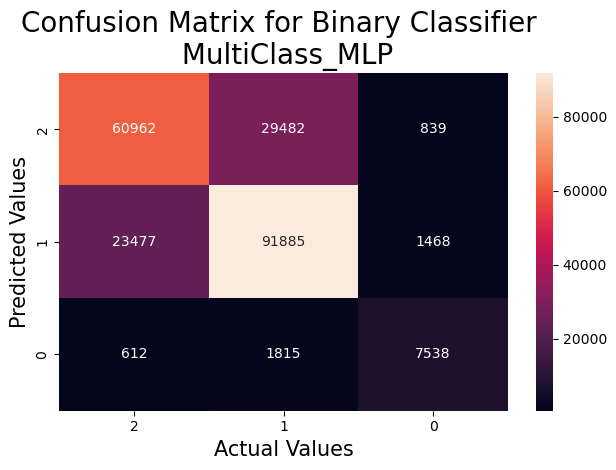

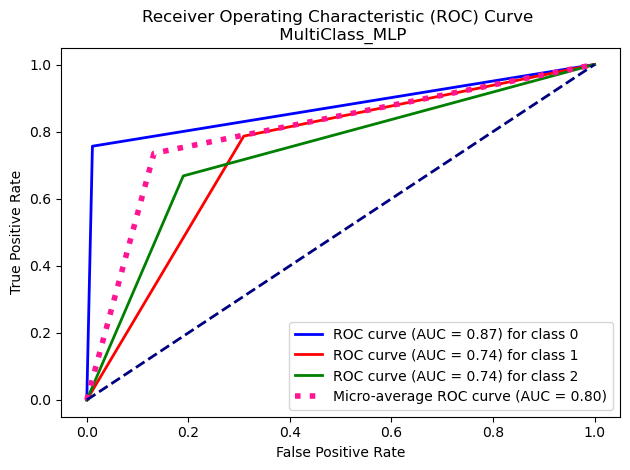

In [35]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [36]:
metadata_test

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels
0,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy
6,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy
7,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy
8,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy
9,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597895,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,81,81,87,87,media_ctr,0.0_None,healthy
597896,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,128,128,135,135,media_ctr,0.0_None,healthy
597898,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,146,146,159,159,media_ctr,0.0_None,healthy
597899,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,221,221,234,234,media_ctr,0.0_None,healthy


In [37]:
# define a final dataframe to store the predictions
final_predictions_df = pd.DataFrame()

In [38]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_test], axis=1)
y_pred_df = pd.concat([y_pred_df, X_test], axis=1)

In [39]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_test.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_test], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [40]:
# save the y_pred_df to a parquet file
# set path
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/testing_single_cell_predictions.parquet"
)
# make path if it doesn't exist
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# save the dataframe
y_pred_df.to_parquet(y_pred_df_path)

In [41]:
y_pred_df["data_split"] = "test"

In [42]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0.806753,1.127894,-1.621196,-0.939418,-0.459493,-1.559829,-0.653718,-1.368565,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,1,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
8,1,1,-0.012046,-0.018079,-0.197359,-0.323890,-0.120228,0.258473,-1.462321,-0.347762,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy,test
9,1,1,-0.353703,-0.767519,0.624540,0.064788,0.080988,1.166685,-0.322262,0.968496,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597895,1,1,-0.406369,1.290748,-0.220145,0.135402,2.218792,-0.427815,-0.926437,-0.815460,...,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,81,81,87,87,media_ctr,0.0_None,healthy,test
597896,1,1,-1.280182,0.907755,2.322952,2.120562,-0.362151,-1.114296,-0.015486,0.811810,...,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,128,128,135,135,media_ctr,0.0_None,healthy,test
597898,0,1,-0.575085,0.961826,0.394708,0.386171,0.600712,-0.471124,-1.101421,0.245070,...,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,146,146,159,159,media_ctr,0.0_None,healthy,test


In [43]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [44]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,7538,1815,612
healthy,1468,91885,23477
pyroptosis,839,29482,60962


In [45]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [46]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,1815,testing
1,healthy,healthy,91885,testing
2,pyroptosis,healthy,29482,testing
3,apoptosis,apoptosis,7538,testing
4,healthy,apoptosis,1468,testing
5,pyroptosis,apoptosis,839,testing
6,apoptosis,pyroptosis,612,testing
7,healthy,pyroptosis,23477,testing
8,pyroptosis,pyroptosis,60962,testing


In [47]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [48]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,0.765668,0.014734,0.007196
healthy,0.149111,0.745929,0.276034
pyroptosis,0.085221,0.239337,0.716770


In [49]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

In [50]:
data_split_conf_mat_df_all

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,1815,testing,0.014734,False
1,healthy,healthy,91885,testing,0.745929,False
2,pyroptosis,healthy,29482,testing,0.239337,False
3,apoptosis,apoptosis,7538,testing,0.765668,False
4,healthy,apoptosis,1468,testing,0.149111,False
5,pyroptosis,apoptosis,839,testing,0.085221,False
6,apoptosis,pyroptosis,612,testing,0.007196,False
7,healthy,pyroptosis,23477,testing,0.276034,False
8,pyroptosis,pyroptosis,60962,testing,0.716770,False


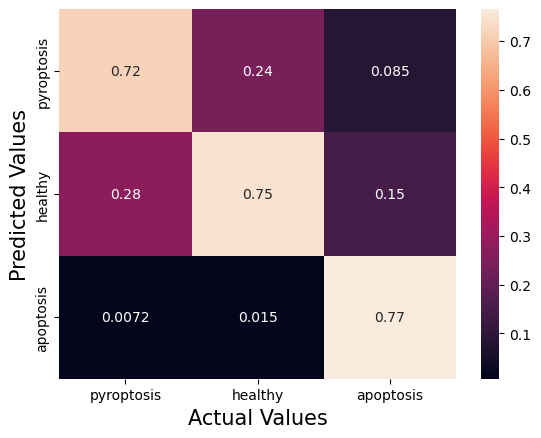

In [51]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [52]:
stats_df = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9965
           1       0.75      0.79      0.77    116830
           2       0.72      0.67      0.69     91283

    accuracy                           0.74    218078
   macro avg       0.74      0.74      0.74    218078
weighted avg       0.73      0.74      0.73    218078



/tmp/ipykernel_84456/2182903883.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [53]:
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_84456/1771591469.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the treatment holdout data on the model

MultiClass_MLP


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.64      0.78     22551

    accuracy                           0.64     22551
   macro avg       0.33      0.21      0.26     22551
weighted avg       1.00      0.64      0.78     22551

Precision for class 0: 0.0
Recall for class 0: 0.0
Precision for class 1: 0.0
Recall for class 1: 0.0
Precision for class 2: 1.0
Recall for class 2: 0.6385082701432309
3


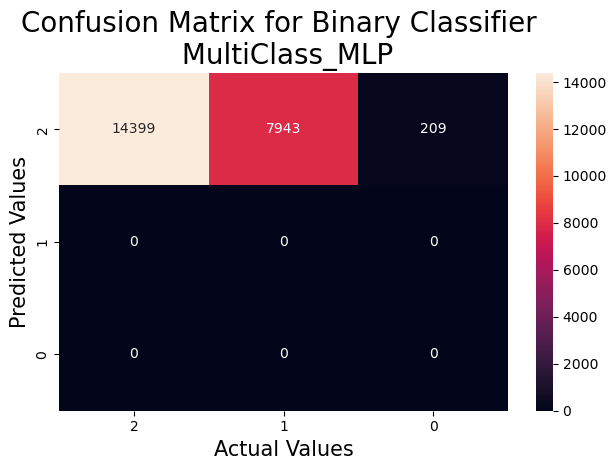

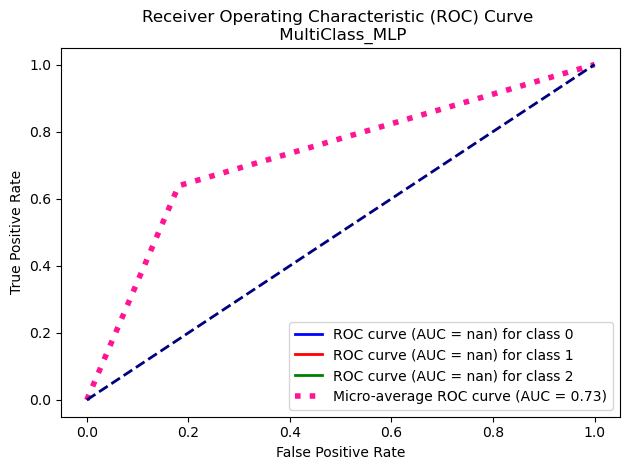

In [54]:
treatment_holdout_data = Dataset_formatter(
    torch.FloatTensor(X_treatment_holdout.values),
    torch.FloatTensor(Y_treatment_holdout.values),
)

# convert data class into a dataloader to be compatible with pytorch
treatment_holdout_loader = torch.utils.data.DataLoader(
    dataset=treatment_holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_treatment_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [55]:
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0.806753,1.127894,-1.621196,-0.939418,-0.459493,-1.559829,-0.653718,-1.368565,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,1,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
8,1,1,-0.012046,-0.018079,-0.197359,-0.323890,-0.120228,0.258473,-1.462321,-0.347762,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy,test
9,1,1,-0.353703,-0.767519,0.624540,0.064788,0.080988,1.166685,-0.322262,0.968496,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597895,1,1,-0.406369,1.290748,-0.220145,0.135402,2.218792,-0.427815,-0.926437,-0.815460,...,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,81,81,87,87,media_ctr,0.0_None,healthy,test
597896,1,1,-1.280182,0.907755,2.322952,2.120562,-0.362151,-1.114296,-0.015486,0.811810,...,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,128,128,135,135,media_ctr,0.0_None,healthy,test
597898,0,1,-0.575085,0.961826,0.394708,0.386171,0.600712,-0.471124,-1.101421,0.245070,...,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,146,146,159,159,media_ctr,0.0_None,healthy,test


In [56]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_treatment_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_treatment_holdout], axis=1)

In [57]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_treatment_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_treatment_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [58]:
y_pred_df["data_split"] = "treatment_holdout"

In [59]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0.806753,1.127894,-1.621196,-0.939418,-0.459493,-1.559829,-0.653718,-1.368565,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,1,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
8,1,1,-0.012046,-0.018079,-0.197359,-0.323890,-0.120228,0.258473,-1.462321,-0.347762,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy,test
9,1,1,-0.353703,-0.767519,0.624540,0.064788,0.080988,1.166685,-0.322262,0.968496,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509986,2,2,-0.375438,-1.891302,0.559411,0.093526,1.453126,3.996784,-1.095977,0.837859,...,663,*70117_20230210MM1_Gasdermin514_CP_BC430856,68,68,75,75,LPS_Nigericin,1.000_µg_per_ml_3.000_µM,pyroptosis,treatment_holdout
509987,2,2,0.333951,0.356476,0.568357,-0.625702,2.401153,2.426867,-0.729466,0.269782,...,663,*70117_20230210MM1_Gasdermin514_CP_BC430856,130,130,143,143,LPS_Nigericin,1.000_µg_per_ml_3.000_µM,pyroptosis,treatment_holdout
509988,2,2,-0.677934,-1.221339,0.204682,0.560479,-1.008863,-0.067931,0.884120,0.831670,...,663,*70117_20230210MM1_Gasdermin514_CP_BC430856,57,57,64,64,LPS_Nigericin,1.000_µg_per_ml_3.000_µM,pyroptosis,treatment_holdout


In [60]:
# # save the y_pred_df to a parquet file
# # set path
# y_pred_df_path = pathlib.Path(
#     f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/treatment_holdout_single_cell_predictions.parquet"
# )
# # make path if it doesn't exist
# y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# # save the dataframe
# y_pred_df.to_parquet(y_pred_df_path)

In [61]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [62]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [63]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,0,holdout
1,healthy,healthy,0,holdout
2,pyroptosis,healthy,7943,holdout
3,apoptosis,apoptosis,0,holdout
4,healthy,apoptosis,0,holdout
5,pyroptosis,apoptosis,209,holdout
6,apoptosis,pyroptosis,0,holdout
7,healthy,pyroptosis,0,holdout
8,pyroptosis,pyroptosis,14399,holdout


In [64]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [65]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [66]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_84456/3876124126.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


In [67]:
data_split_conf_mat_df

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,0,holdout,0.0,False
1,healthy,healthy,0,holdout,0.0,False
2,pyroptosis,healthy,7943,holdout,1.0,False
3,apoptosis,apoptosis,0,holdout,0.0,False
4,healthy,apoptosis,0,holdout,0.0,False
5,pyroptosis,apoptosis,209,holdout,1.0,False
6,apoptosis,pyroptosis,0,holdout,0.0,False
7,healthy,pyroptosis,0,holdout,0.0,False
8,pyroptosis,pyroptosis,14399,holdout,1.0,False


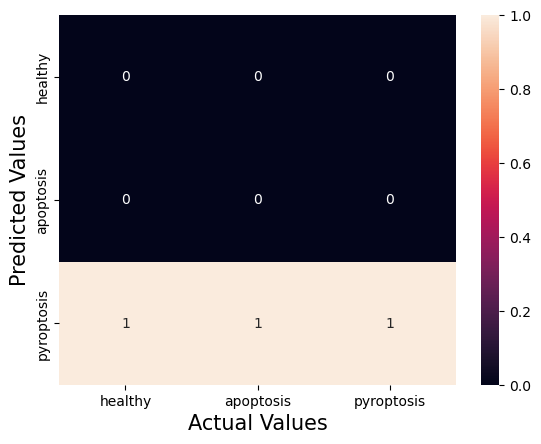

In [68]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [69]:
stats_df = output_stats(
    y_pred_list,
    Y_treatment_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.64      0.78     22551

    accuracy                           0.64     22551
   macro avg       0.33      0.21      0.26     22551
weighted avg       1.00      0.64      0.78     22551



/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_84456/1166240676.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [70]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_84456/2184599894.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.896417,train,False
1,healthy,precision,0.825032,train,False
2,pyroptosis,precision,0.753142,train,False
3,accuracy,accuracy,0.801177,train,False
4,macro avg,precision,0.824864,train,False
...,...,...,...,...,...
19,healthy,support,0.000000,holdout,False
20,pyroptosis,support,22551.000000,holdout,False
21,accuracy,accuracy,0.638508,holdout,False
22,macro avg,support,22551.000000,holdout,False


## Test the hold out wells

MultiClass_MLP
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      7048
           1       0.74      0.78      0.76     77041
           2       0.73      0.69      0.71     66812

    accuracy                           0.74    150901
   macro avg       0.76      0.74      0.75    150901
weighted avg       0.74      0.74      0.74    150901

Precision for class 0: 0.795664696073973
Recall for class 0: 0.744750283768445
Precision for class 1: 0.7366367586062598
Recall for class 1: 0.7768720551394712
Precision for class 2: 0.7335817936721909
Recall for class 2: 0.6923307190325091
3


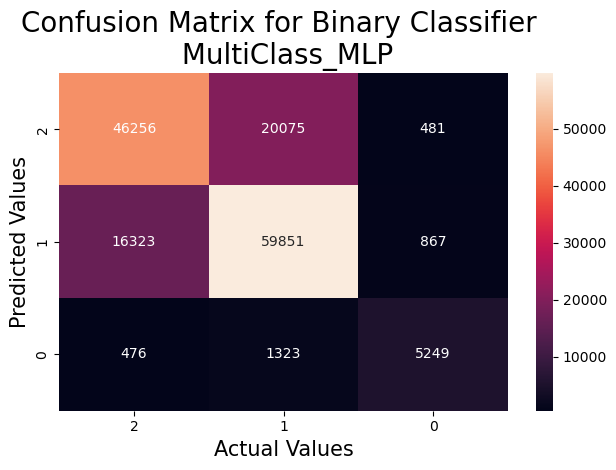

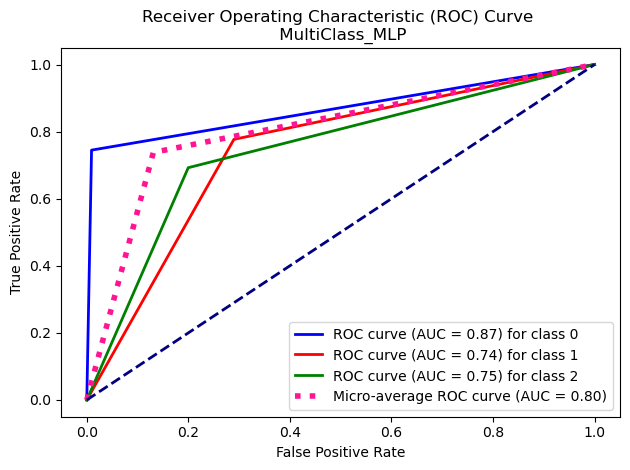

In [71]:
holdout_data = Dataset_formatter(
    torch.FloatTensor(X_holdout.values), torch.FloatTensor(Y_holdout.values)
)

# convert data class into a dataloader to be compatible with pytorch
holdout_loader = torch.utils.data.DataLoader(
    dataset=holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [72]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_holdout], axis=1)

In [73]:
y_pred_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_02_256,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_CorrMito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_02_256,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrGasdermin_3_01_256,Nuclei_Texture_SumVariance_CorrMito_3_03_256,Nuclei_Texture_SumVariance_CorrPM_3_03_256
0,1,1,0.797096,-0.537727,-1.174054,-0.933880,-1.116239,-0.557981,-1.206480,-0.619424,...,-0.162768,-0.346097,0.292044,-0.521134,-0.301617,-0.606058,0.143578,-0.058468,-0.027652,-0.013390
1,2,1,-0.439083,0.755107,0.579506,0.180986,-0.409908,-0.929612,0.078766,0.035048,...,-0.071910,0.201187,0.110625,0.121665,-0.469146,-1.098503,0.648315,-0.061307,-0.102799,-0.022139
2,1,1,-0.590661,0.140809,0.888220,0.411432,-0.347490,-0.153971,0.941599,0.680707,...,1.481263,0.690523,0.487771,0.255094,-0.186759,0.249903,-0.163324,-0.065590,-0.110584,-0.049082
3,2,1,-0.131247,-0.408269,0.828719,-0.200433,-0.172184,0.550159,-0.323960,0.560671,...,0.003445,0.381826,0.558444,-0.739083,-1.031498,0.274421,0.422075,-0.057480,-0.064175,-0.035624
4,1,1,-0.580644,0.127624,0.573203,0.395143,-0.496440,-0.304607,1.102797,0.334479,...,0.732186,0.257969,-0.157212,-0.155533,0.418969,0.384485,-0.105365,-0.057762,-0.061151,-0.045665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150896,1,1,-0.148761,0.604165,-0.161017,-0.181287,-0.245968,-0.580142,0.390559,-0.674253,...,-0.324930,-0.635156,-0.953893,-0.082914,-1.629234,-0.887545,0.634636,-0.058566,-0.104383,-0.033770
150897,1,1,0.118484,-0.516577,-0.181496,-0.446729,-0.302140,0.471772,-1.470387,0.593381,...,-0.407035,-0.514684,-0.214748,0.973535,0.487932,0.516653,0.227707,-0.051122,-0.113096,-0.037129
150898,1,1,-0.644262,-0.679431,-0.374136,0.501408,-0.463848,0.378950,0.245302,0.249623,...,-3.023609,-2.961772,-2.587951,-1.690488,-0.650822,-0.656706,0.753205,0.288475,0.241297,0.114880
150899,1,1,-0.717292,0.343966,0.914847,0.632182,-0.703644,-0.731752,0.919683,0.486756,...,1.430995,0.317378,0.238976,0.909340,0.458996,-0.073209,-0.193513,-0.058712,-0.120679,-0.052694


In [74]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [75]:
y_pred_df["data_split"] = "holdout"

In [76]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0.806753,1.127894,-1.621196,-0.939418,-0.459493,-1.559829,-0.653718,-1.368565,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,1,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
8,1,1,-0.012046,-0.018079,-0.197359,-0.323890,-0.120228,0.258473,-1.462321,-0.347762,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy,test
9,1,1,-0.353703,-0.767519,0.624540,0.064788,0.080988,1.166685,-0.322262,0.968496,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584185,1,1,-0.148761,0.604165,-0.161017,-0.181287,-0.245968,-0.580142,0.390559,-0.674253,...,541,*70117_20230210MM1_Gasdermin514_CP_BC430856,185,185,188,188,H2O2,100.000_µM,healthy,holdout
584186,1,1,0.118484,-0.516577,-0.181496,-0.446729,-0.302140,0.471772,-1.470387,0.593381,...,542,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,7,7,H2O2,100.000_µM,healthy,holdout
584187,1,1,-0.644262,-0.679431,-0.374136,0.501408,-0.463848,0.378950,0.245302,0.249623,...,542,*70117_20230210MM1_Gasdermin514_CP_BC430856,129,129,141,141,H2O2,100.000_µM,healthy,holdout


In [77]:
# # save the y_pred_df to a parquet file
# # set path
# y_pred_df_path = pathlib.Path(
#     f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/holdout_single_cell_predictions.parquet"
# )
# # make path if it doesn't exist
# y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# # save the dataframe
# y_pred_df.to_parquet(y_pred_df_path)

In [78]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [79]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [80]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,1323,holdout
1,healthy,healthy,59851,holdout
2,pyroptosis,healthy,20075,holdout
3,apoptosis,apoptosis,5249,holdout
4,healthy,apoptosis,867,holdout
5,pyroptosis,apoptosis,481,holdout
6,apoptosis,pyroptosis,476,holdout
7,healthy,pyroptosis,16323,holdout
8,pyroptosis,pyroptosis,46256,holdout


In [81]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [82]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [83]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_84456/3876124126.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


In [84]:
data_split_conf_mat_df

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,1323,holdout,0.016283,False
1,healthy,healthy,59851,holdout,0.736637,False
2,pyroptosis,healthy,20075,holdout,0.247080,False
3,apoptosis,apoptosis,5249,holdout,0.795665,False
4,healthy,apoptosis,867,holdout,0.131423,False
5,pyroptosis,apoptosis,481,holdout,0.072912,False
6,apoptosis,pyroptosis,476,holdout,0.007549,False
7,healthy,pyroptosis,16323,holdout,0.258869,False
8,pyroptosis,pyroptosis,46256,holdout,0.733582,False


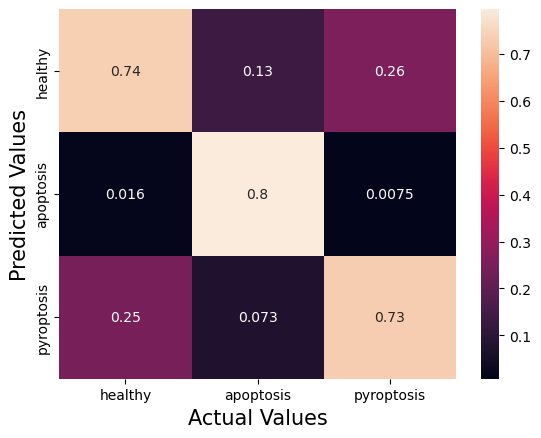

In [85]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [86]:
stats_df = output_stats(
    y_pred_list,
    Y_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      7048
           1       0.74      0.78      0.76     77041
           2       0.73      0.69      0.71     66812

    accuracy                           0.74    150901
   macro avg       0.76      0.74      0.75    150901
weighted avg       0.74      0.74      0.74    150901



/tmp/ipykernel_84456/2531832601.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [87]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_84456/2184599894.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.896417,train,False
1,healthy,precision,0.825032,train,False
2,pyroptosis,precision,0.753142,train,False
3,accuracy,accuracy,0.801177,train,False
4,macro avg,precision,0.824864,train,False
...,...,...,...,...,...
19,healthy,support,77041.000000,holdout,False
20,pyroptosis,support,66812.000000,holdout,False
21,accuracy,accuracy,0.737941,holdout,False
22,macro avg,support,150901.000000,holdout,False


In [94]:
# set path for the model confusion matrices
predictions_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
predictions_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{predictions_path}/single_cell_predictions.parquet")
if matrix_file.exists():
    predictions_df_tmp = pd.read_parquet(matrix_file)
    if len(predictions_df_tmp["shuffled_data"].unique()) > 1:
        pass
    elif predictions_df_tmp["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, final_predictions_df], axis=0)
        metrics_df.to_parquet(matrix_file, index=False)
else:
    final_predictions_df.to_parquet(matrix_file, index=False)

In [90]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.csv")
if matrix_file.exists():
    metrics_df = pd.read_csv(matrix_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_csv(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_csv(matrix_file, index=False)

In [92]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)